In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('..')
import pandas as pd
import seaborn as sns
import input_pipeline
from results import get_df, get_stats, final_plot

2024-04-02 09:15:18.716518: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 09:15:19.011813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 09:15:19.011869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 09:15:19.028112: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 09:15:19.078166: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 09:15:19.078993: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Helper functions

In [2]:
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   

def sample(num, generator, noise_dim=100):
    random_vector_for_generation = tf.random.normal([num, 1, 1, noise_dim])
    return generator(random_vector_for_generation)

def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data

def load_model_at_T(t, folder):
    generator = tf.keras.models.load_model(f"results/{folder}/{t:.1f}/generator")
    return generator

## Models dictionary

In [3]:
temps = np.arange(2.0, 3.0, 0.1)
folder = 'gan_v1'

# Compare with monte carlo

# Data

In [9]:
data_list = []
with tf.device('CPU:0'):
    for temp in temps:
        # Monte Carlo
        trainset_path = f"../../GetData/Python/Data/Data{temp:.2}.tfrecord"
        batch_size = 10000
        train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
        data_mc = next(iter(train_set))
        data_mc = 2 * data_mc - 1
        df_monte_carlo = get_df(data_mc)
        mc_stats = get_stats(df_monte_carlo, temp)
        mc_stats.extend((temp, "Monte Carlo"))
    
        model = load_model_at_T(temp, folder)
        sample_data = []
        sample_data = sample(batch_size, model)
        spin_sample = 2 * np.round(sample_data) - 1
        spin_sample = random_swap(spin_sample)
        df_sampled = get_df(spin_sample)
        sample_stats = get_stats(df_sampled, temp)
        sample_stats.extend((temp, "GAN"))
    
        data_list.append(mc_stats)
        data_list.append(sample_stats)

2024-04-02 09:18:03.218741: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-04-02 09:18:10.582271: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-04-02 09:18:10.687871: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.
2024-04-02 09:18:10.778744: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-04-02 09:18:31.002169: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.


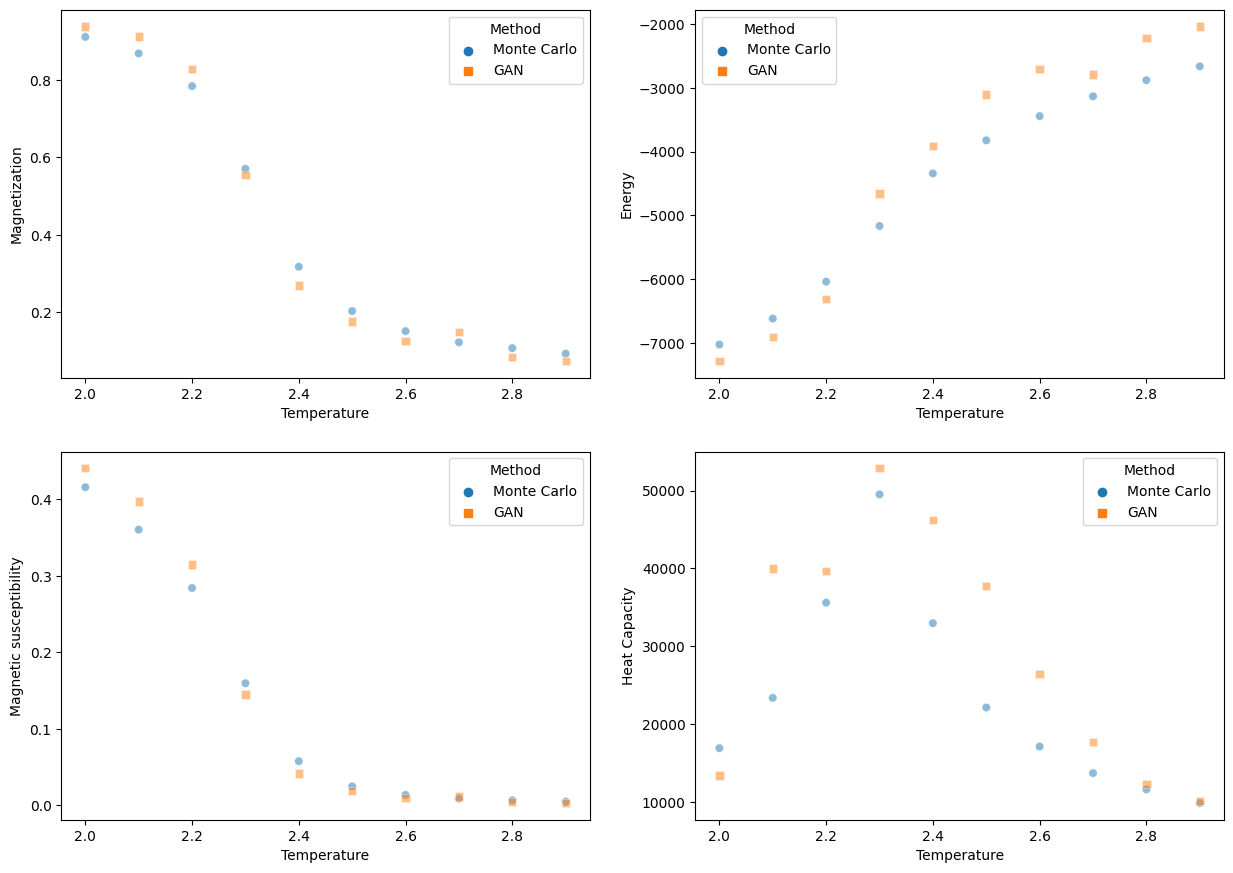

In [10]:
final_plot(data_list)
plt.savefig("final_plot.png")

## Examples

In [ ]:
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(10, 20))
for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    predictions = sample(5, models[temps[i]])
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[j, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.tight_layout()